In [55]:
import numpy as np
import torch as tr
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import itertools

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm


https://theaisummer.com/simclr/#indexing-the-similarity-matrix-for-the-simclr-loss-function

## Data loading- medical MNIST

In [97]:
# Define a function to convert grayscale images to RGB
def grayscale_to_rgb(img):
    return torch.cat((img, img, img), dim=0)

# Set up the data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST training dataset
train_set = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Create a PyTorch DataLoader for the training set
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=12,
    shuffle=True
)

# Load the MNIST test dataset
test_set = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create a PyTorch DataLoader for the test set
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=12,
    shuffle=False
)

In [ ]:
torch.utils.data.DataLoader?

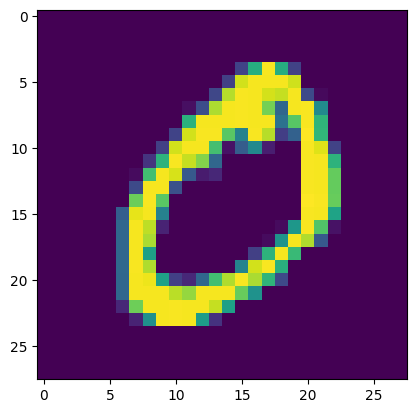

In [98]:
import matplotlib.pyplot as plt
plt.imshow(train_set.data[1])

In [99]:
# Get the first 10 samples from the DataLoader
sub_train_loader = list(itertools.islice(train_loader, 10))

for i, (inputs, targets) in enumerate(sub_train_loader):

    print(f'Batch {i}, Inputs shape: {inputs.shape}, Targets shape: {targets.shape}')

Batch 0, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 1, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 2, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 3, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 4, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 5, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 6, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 7, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 8, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])
Batch 9, Inputs shape: torch.Size([12, 3, 28, 28]), Targets shape: torch.Size([12])


In [113]:

# Define the SimCLR network architecture
class SimCLR(nn.Module):
    def __init__(self,verbose=False):
        super(SimCLR, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(28, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.verbose = verbose

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z = self.projector(h)
        if self.verbose:
            print('batch size is ',x.shape)
            print('encoded size is ',h.shape)
            print('final size is ',z.shape)
        return h,z

# model = SimCLR()
# h, z = model(inputs)

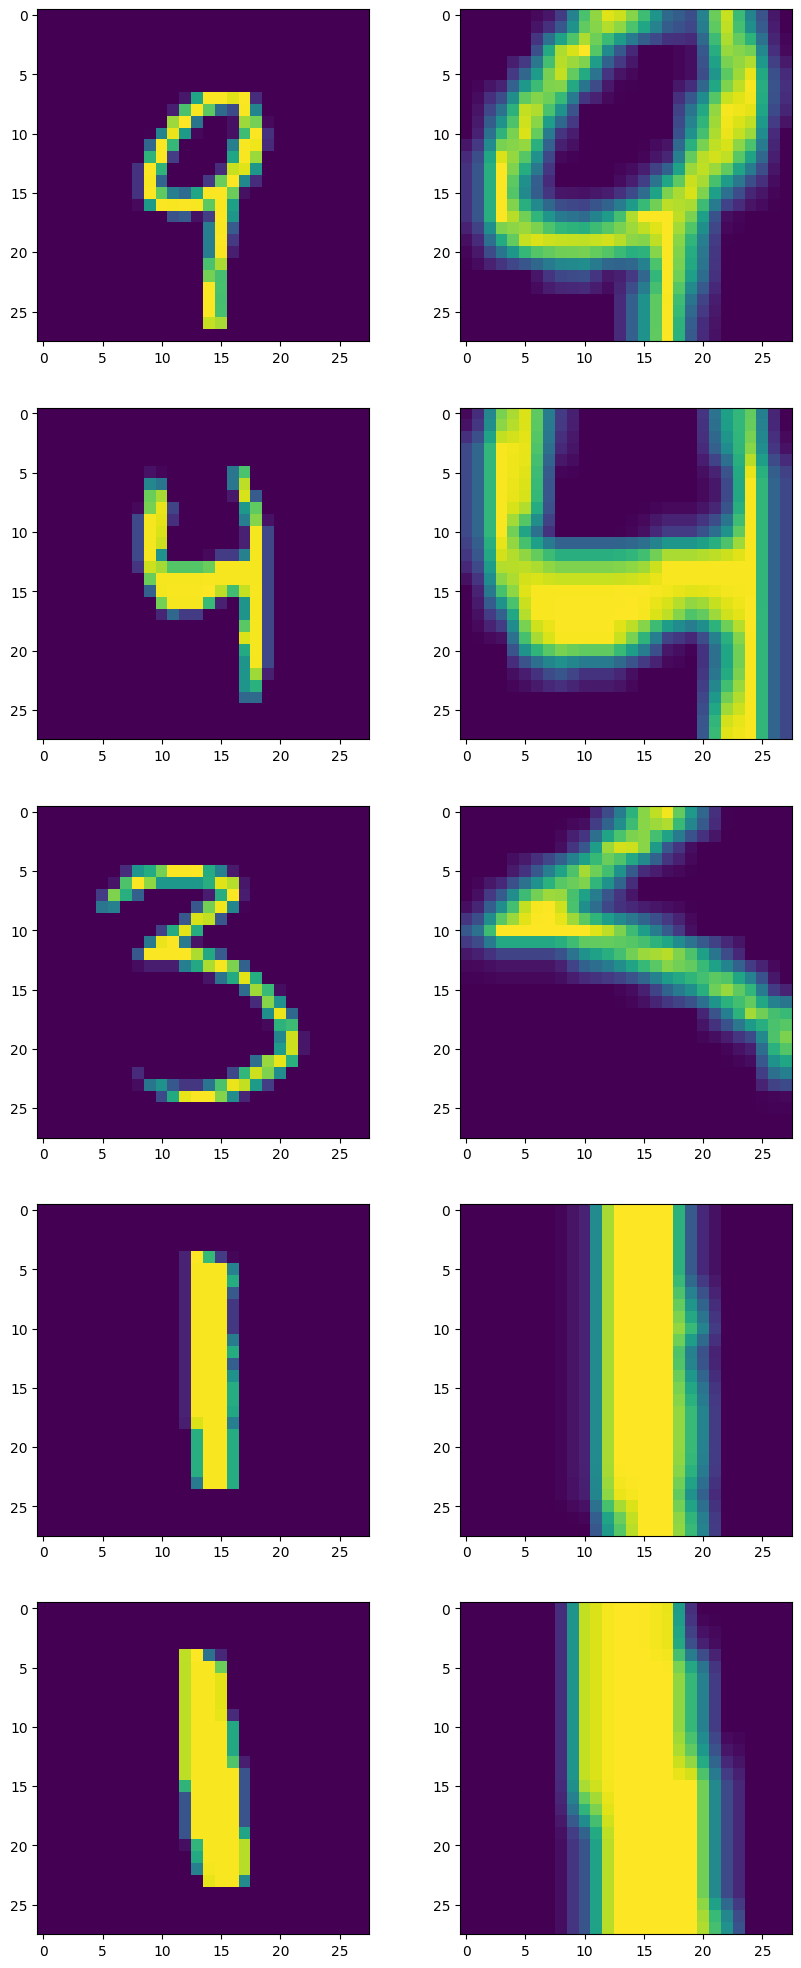

In [102]:
def visualize_batch(x_i,x_j):
  N,C,H,W = x_i.shape
  Nplt = np.min([5,N])
  fg,axar = plt.subplots(Nplt,2,figsize=(10,5*Nplt))
  for ix in range(Nplt):
    ax1 = axar[ix,0]
    ax2 = axar[ix,1]
    ax1.imshow(x_i[ix,0])
    ax2.imshow(x_j[ix,0])
  return None
visualize_batch(x_i,x_j)

## Loss

In [111]:
def device_as(t1, t2):
   """
   Moves t1 to the device of t2
   """
   return t1.to(t2.device)
class ContrastiveLoss(nn.Module):
   """
   Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
   """
   def __init__(self, batch_size, temperature=0.5):
       super().__init__()
       self.batch_size = batch_size
       self.temperature = temperature
       self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()

   def calc_similarity_batch(self, a, b):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

   def forward(self, proj_1, proj_2):
       """
       proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
       where corresponding indices are pairs
       z_i, z_j in the SimCLR paper
       """
       batch_size = proj_1.shape[0]
       z_i = F.normalize(proj_1, p=2, dim=1)
       z_j = F.normalize(proj_2, p=2, dim=1)

       similarity_matrix = self.calc_similarity_batch(z_i, z_j)

       sim_ij = torch.diag(similarity_matrix, batch_size)
       sim_ji = torch.diag(similarity_matrix, -batch_size)

       positives = torch.cat([sim_ij, sim_ji], dim=0)

       nominator = torch.exp(positives / self.temperature)

       denominator = device_as(self.mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

       all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
       loss = torch.sum(all_losses) / (2 * self.batch_size)
       return loss

In [125]:
model = SimCLR()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = ContrastiveLoss(train_loader.batch_size)

In [126]:
num_epochs = 1000
loss = -99 * np.ones((num_epochs))
# h_is = -99 * np.ones((num_epochs))
# h_js = -99 * np.ones((num_epochs))

for ep in range(num_epochs):
    loss_epoch = 0
    for i, (inputs, targets) in enumerate(sub_train_loader):
        optimizer.zero_grad()
        x_i = inputs
        x_j =  torchvision.transforms.functional.resized_crop(
            inputs,
            top=8,
            left=8,
            height=12,
            width=12,
            size=(28,28)
        )

        h_i, z_i = model(x_i)
        h_j, z_j = model(x_j)

        batch_loss = criterion(z_i, z_j)
        batch_loss.backward()
        optimizer.step()
        loss_epoch += batch_loss.item()
    loss[ep] = loss_epoch

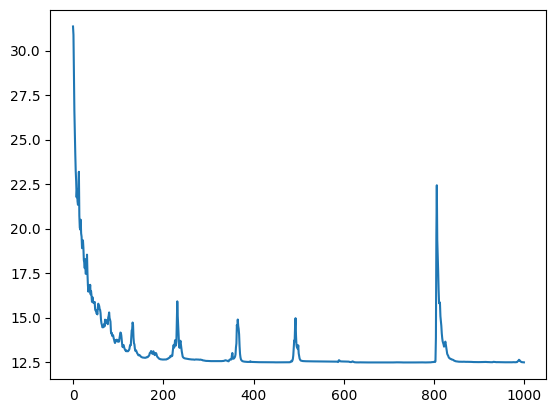

In [128]:
plt.plot(loss)

## Eval 

In [148]:
print(f"x_i shape: {x_i.shape}\nh_i shape: {h_i.shape} \ntargets shape: {targets.shape}")

x_i shape: torch.Size([12, 3, 28, 28])
h_i shape: torch.Size([12, 512]) 
targets shape: torch.Size([12])


In [170]:
x_i_flat = x_i.reshape(12, -1)
targets_pad = targets.float().unsqueeze(1)

print(f"x_i flattened shape: {x_i_flat.shape} \ntargets packed shape: {targets_pad.shape}")

x_i flattened shape: torch.Size([12, 2352]) 
targets packed shape: torch.Size([12, 1])


In [171]:
X = torch.linalg.lstsq(x_i_flat, targets_pad).solution

In [172]:
torch.dist(X, torch.linalg.pinv(x_i_flat) @ targets_pad)

tensor(0.4069)